# SDVRP example notebook

In this notebook we will cover a quickstart training of the Split Delivery Vehicle Routing Problem (SDVRP), with some additional comments along the way. The SDVRP is a variant of the VRP where a vehicle can deliver a part of the demand of a customer and return later to deliver the rest of the demand.




<a href="https://colab.research.google.com/github/kaist-silab/rl4co/blob/main/notebooks/examples/1-example-sdvrp.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>



## Installation

Uncomment the following line to install the package from PyPI. Remember to choose a GPU runtime for faster training!

> Note: You may need to restart the runtime in Colab after this


In [1]:
# !pip install rl4co

## NOTE: to install latest version from Github (may be unstable) install from source instead:
# !pip install git+https://github.com/kaist-silab/rl4co.git

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

from omegaconf import DictConfig

import torch
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, RichModelSummary

from rl4co.envs import SDVRPEnv
from rl4co.models.zoo.am import AttentionModel
from rl4co.tasks.rl4co import RL4COLitModule

/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/torchrl/__init__.py:26: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(


## Main Setup

### Configuration

This is can be either handled by Hydra or directly passed to the `RL4COLitModule`. You may add other parameters for it as well

In [3]:
config = DictConfig(
    {"data": {
        "train_size": 100000,
        "val_size": 10000,
        "batch_size": 512,
    },
    "optimizer": {"lr": 1e-4}}
)

### Environment, Model and LitModule

In [4]:
env = SDVRPEnv(num_loc=20) # TorchRL environment
model = AttentionModel(env) # default is REINFORCE with greedy rollout baseline
lit_module = RL4COLitModule(config, env, model) # custom LightningModule

/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
  rank_zero_warn(
/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


### Test greedy rollout with untrained model and plot

Tour lengths: ['19.33', '12.53', '18.37']


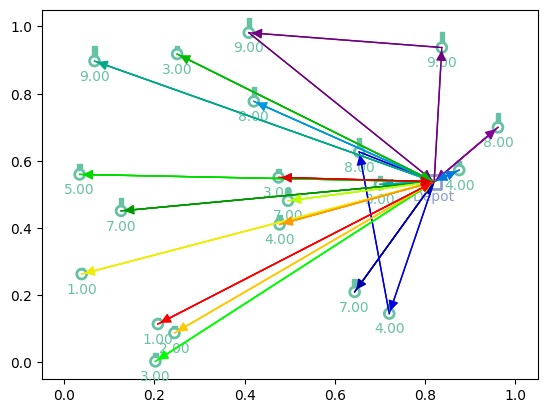

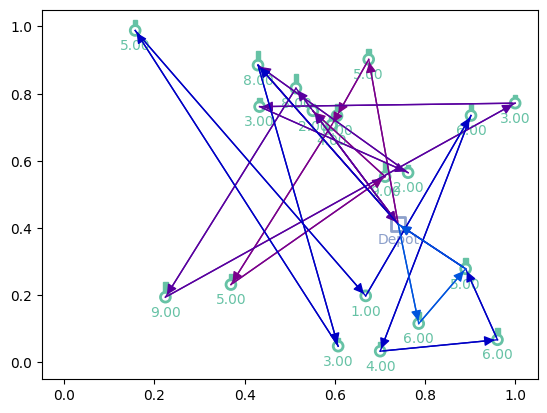

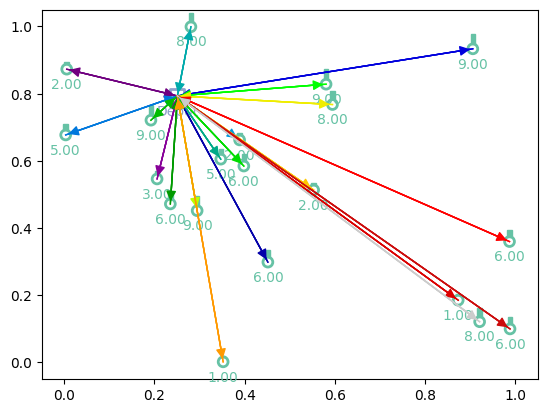

In [5]:
# Greedy rollouts over untrained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = lit_module.model.to(device)
out = model(td_init, phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)

## Training

### Callbacks 

Here we set up a checkpoint callback to save the best model and another callback for demonstration (nice progress bar). You may check other callbacks [here](https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html)


In [6]:
# Checkpointing callback: save models when validation reward improves
checkpoint_callback = ModelCheckpoint(  dirpath="checkpoints", # save to checkpoints/
                                        filename="epoch_{epoch:03d}",  # save as epoch_XXX.ckpt
                                        save_top_k=1, # save only the best model
                                        save_last=True, # save the last model
                                        monitor="val/reward", # monitor validation reward
                                        mode="max") # maximize validation reward

# Print model summary
rich_model_summary = RichModelSummary(max_depth=3)

# Callbacks list
callbacks = [checkpoint_callback, rich_model_summary]

### Logging

Here we will use Wandb. You may comment below lines if you don't want to use it. You may check other loggers [here](https://lightning.ai/docs/pytorch/stable/extensions/logging.html)

We make sure we're logged into W&B so that our experiments can be associated with our account. You may comment the below line if you don't want to use it.

In [7]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: silab-kaist. Use `wandb login --relogin` to force relogin


True

In [8]:
## Comment following two lines if you don't want logging
from lightning.pytorch.loggers import WandbLogger

logger = WandbLogger(project="rl4co", name="sdvrp-am")


## Keep below if you don't want logging
# logger = None

### Lightning Trainer

The Lightning Trainer handles the logging, checkpointing and more for you. 

In [9]:
# Lightning Trainer with few epochs
trainer = L.Trainer(
    max_epochs=3, # only few epochs for showcasing training
    accelerator="gpu", # use GPU if available, else you can use others as "cpu"
    logger=logger, # can replace with WandbLogger, TensorBoardLogger, etc.
    precision="16-mixed", # Faster training with Lightning with mixed precision
    gradient_clip_val=1.0, # clip gradients to avoid exploding gradients
    reload_dataloaders_every_n_epochs=1, # necessary for sampling new data,
    callbacks=callbacks, # may add other callbacks here
)

Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Fit the model

In [10]:
trainer.fit(lit_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
No optimizer specified, using default


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name                           ┃ Type                  ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ env                            │ SDVRPEnv              │      0 │
│ 1 │ model                          │ AttentionModel        │  1.4 M │
│ 2 │ model.policy                   │ AttentionModelPolicy  │  692 K │
│ 3 │ model.policy.encoder           │ GraphAttentionEncoder │  594 K │
│ 4 │ model.policy.decoder           │ Decoder               │ 98.8 K │
│ 5 │ model.baseline                 │ WarmupBaseline        │  692 K │
│ 6 │ model.baseline.baseline        │ RolloutBaseline       │  692 K │
│ 7 │ model.baseline.warmup_baseline │ ExponentialBaseline   │      0 │
└───┴────────────────────────────────┴───────────────────────┴────────┘

Trainable params: 1.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.4 M                                                                                                
Total estimated model params size (MB): 5

Sanity Checking: 0it [00:00, ?it/s]

/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


## Testing

### Plotting

Here we plot the solution (greedy rollout) of the trained model to the initial problem

Tour lengths: ['6.99', '6.68', '7.79']


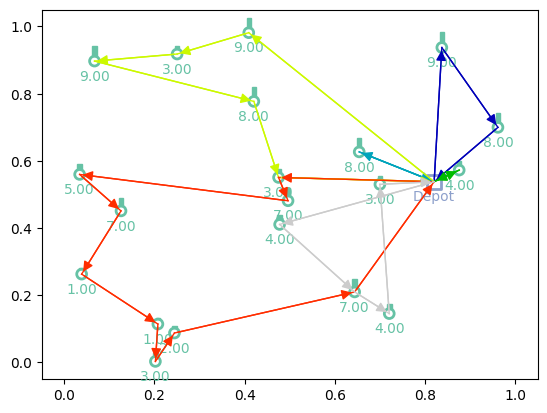

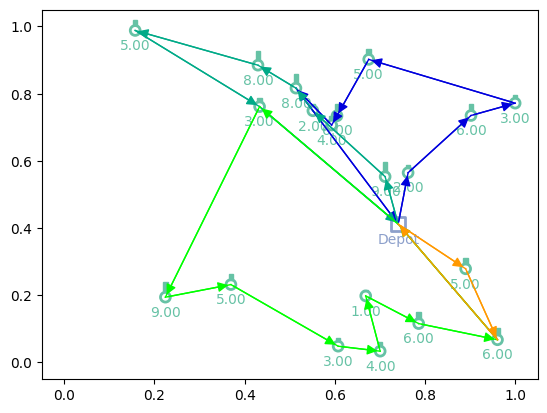

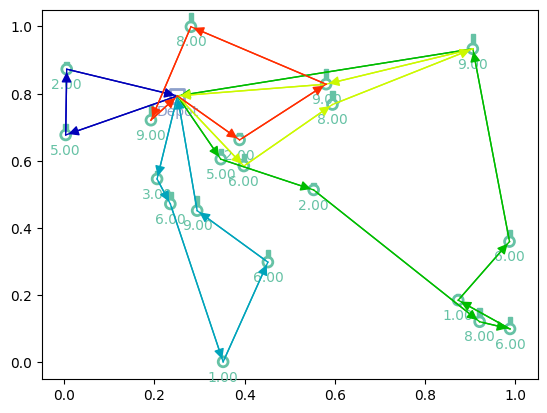

In [11]:
# Greedy rollouts over trained model (same states as previous plot, with 20 nodes)
model = lit_module.model.to(device)
out = model(td_init, phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)

### Test function

By default, the dataset is generated or loaded by the environment. You may load a dataset by setting `test_file` during the env config:

```python
env = SDVRPEnv(
    ...
    test_file="path/to/test/file"
)
```
In this case, we test directly on the generated test dataset

In [12]:
trainer.test(lit_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/reward        │    -7.2381415367126465    │
└───────────────────────────┴───────────────────────────┘

[{'test/reward': -7.2381415367126465}]

### Test generalization to new dataset

Here we can load a new dataset (with 50 nodes) and test the trained model on it

In [13]:
# Test generalization to 50 nodes (not going to be great due to few epochs, but hey)
env = SDVRPEnv(num_loc=50)

# Generate data (100) and set as test dataset
new_dataset = env.dataset(50)
dataloader = lit_module._dataloader(new_dataset, batch_size=100)

### Plotting generalization


Tour lengths: ['14.68', '14.75', '13.97']


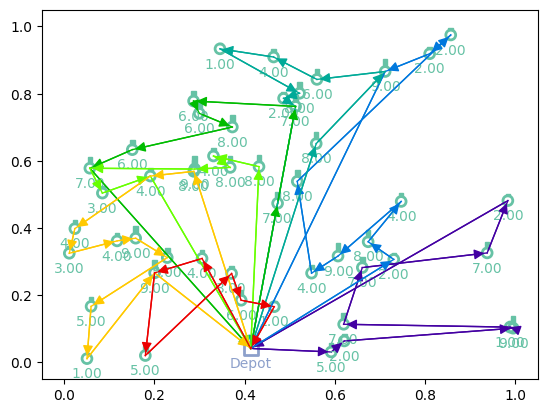

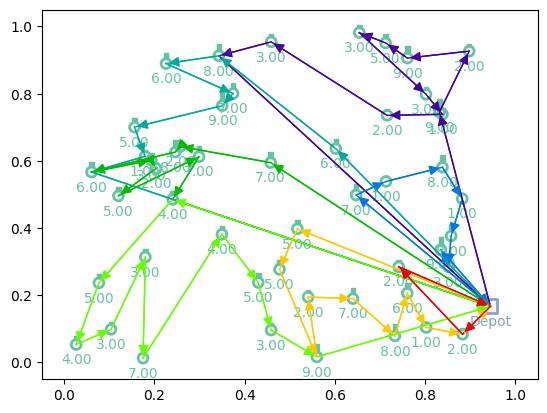

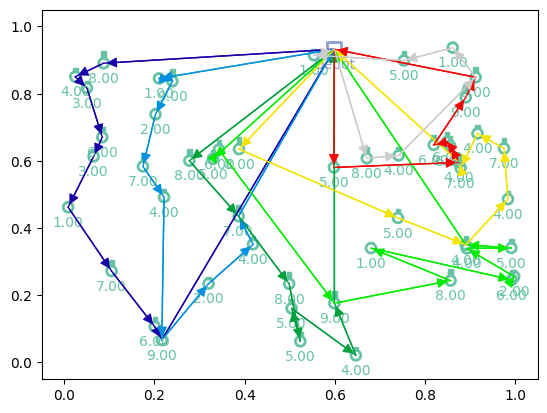

In [14]:
# Greedy rollouts over trained model (same states as previous plot, with 20 nodes)
model = lit_module.model.to(device)
init_states = next(iter(dataloader))[:3]
td_init_generalization = env.reset(init_states).to(device)

out = model(td_init_generalization, phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init_generalization, out['actions'].cpu()):
    env.render(td, actions)

## Loading model

Thanks to PyTorch Lightning,[ we can easily save and load a model to and from a checkpoint](https://lightning.ai/docs/pytorch/stable/common/checkpointing_basic.html)! This is declared in the `Trainer` using the model checkpoint callback. For example, we can load the last model via the `last.ckpt` file located in the folder we specified in the `Trainer`. 

### Checkpointing

In [15]:
%load_ext autoreload
%autoreload 2

from rl4co.tasks.rl4co import RL4COLitModule
# device = "cuda:0"

# Note that by default, Lightning will call checkpoints from newer runs with "-v{version}" suffix
# unless you specify the checkpoint path explicitly
new_model_checkpoint = RL4COLitModule.load_from_checkpoint("checkpoints/last.ckpt")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
  rank_zero_warn(
/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


Now we can load both the model and environment from the checkpoint!

Tour lengths: ['6.99', '6.68', '7.79']


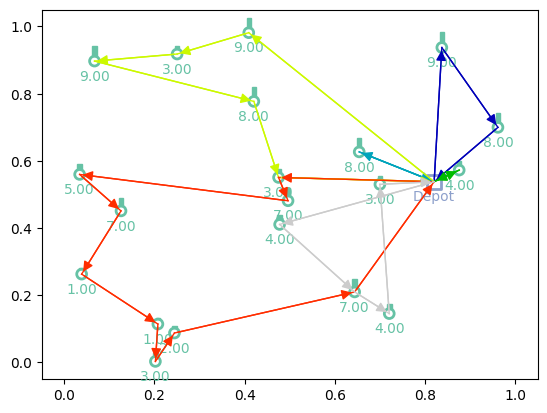

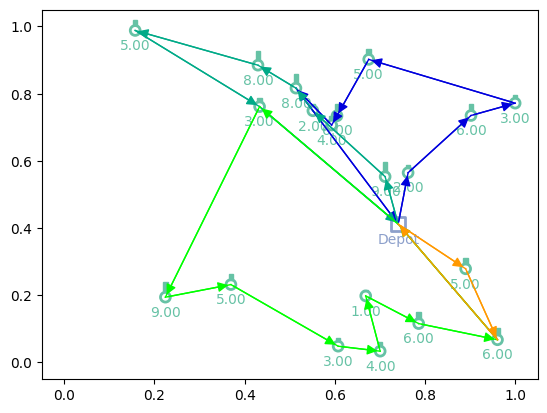

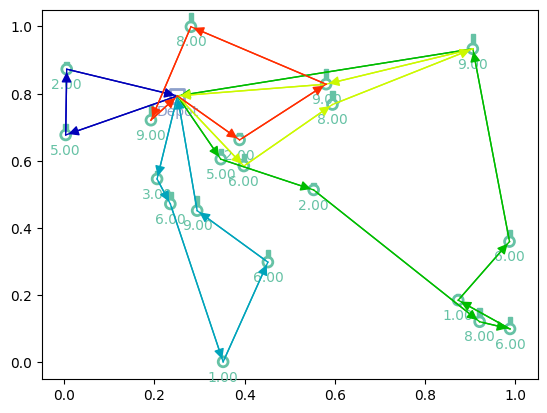

In [16]:
# Greedy rollouts over trained model (same states as previous plot, with 20 nodes)
model = new_model_checkpoint.model.to(device)
env = new_model_checkpoint.env.to(device)

out = model(td_init, phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)

## Additional resources

[**Documentation**](https://rl4co.readthedocs.io/) |  [**Getting Started**](https://github.com/kaist-silab/rl4co/tree/main#getting-started) | [**Usage**](https://github.com/kaist-silab/rl4co/tree/main#usage) | [**Contributing**](#contributing) | [**Paper**](https://arxiv.org/abs/2306.17100) | [**Citation**](#cite-us)

Have feedback about this notebook? Feel free to contribute by either opening an issue or a pull request! ;)